In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

In [66]:
# from google.colab import drive
# import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/StyleTransfer')

In [67]:
import torch
import torch.optim as optim
from torchvision import transforms, models

In [68]:
model = models.vgg19(pretrained=True).features # we don't need the classifiers
for param in model.parameters():
    param.requires_grad = False

In [69]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

mps


In [70]:
from PIL import Image

def prepare_img(path, max_size=400, shape=None):
    img = Image.open(path).convert('RGB')
    if shape is not None:
        size = shape
    elif max(img.size) > max_size:
        size = max_size
    else:
        size = max(img.size)

    transformer = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    img = transformer(img)[:3,:,:].unsqueeze(0)
    return img

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [71]:
content = prepare_img('data/city1.jpg').to(device)
style = prepare_img('data/delaunay.jpg', shape=content.shape[-2:]).to(device)

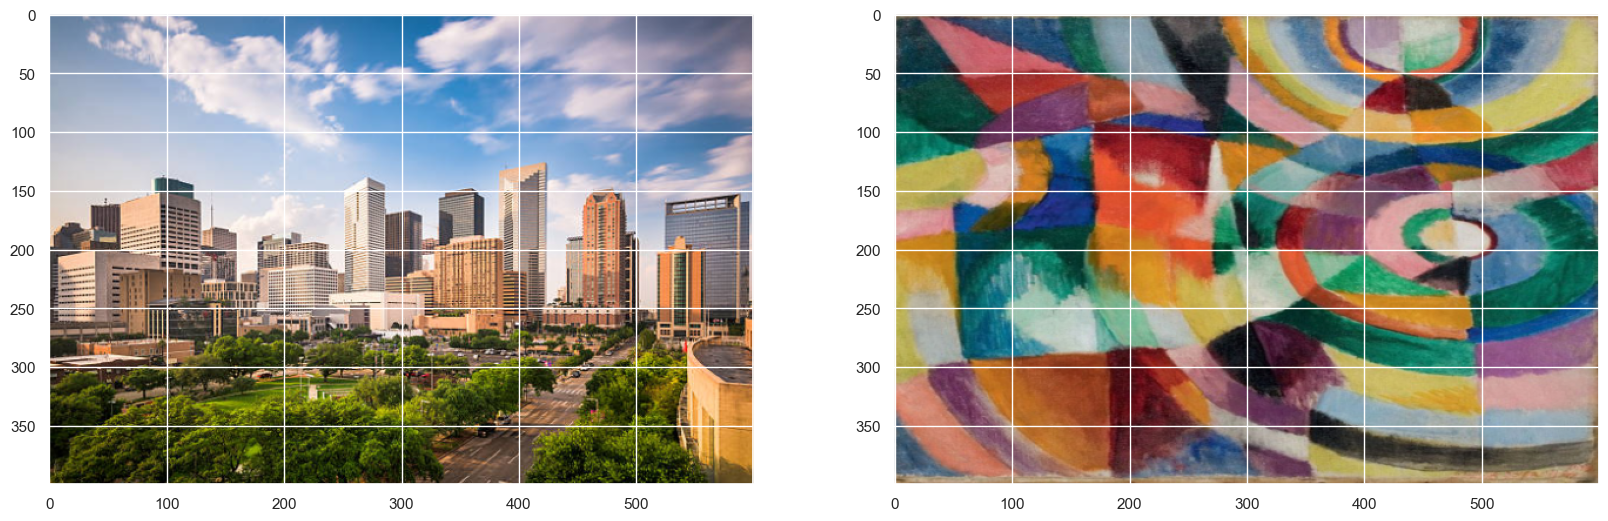

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [73]:
def get_features(img, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', #content
                  '28': 'conv5_1'}

    features = {}
    for name, layer in model._modules.items():
        img = layer(img)
        if name in layers:
            features[layers[name]] = img

    return features

In [74]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [75]:
content_features = get_features(content, model)
style_features = get_features(style, model)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [76]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

style_weight = 1e6
content_weight = 1

Total loss:  326613216.0


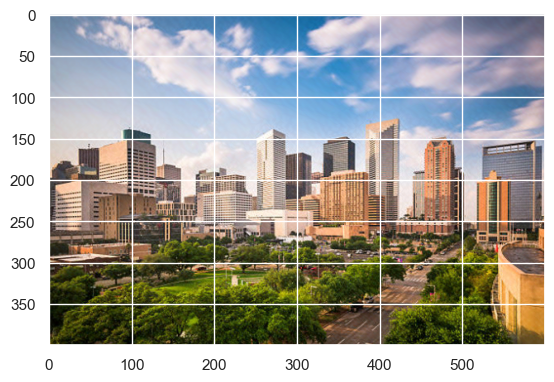

Total loss:  217832624.0


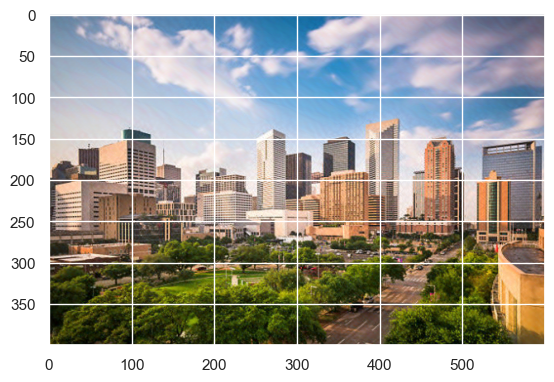

Total loss:  161802912.0


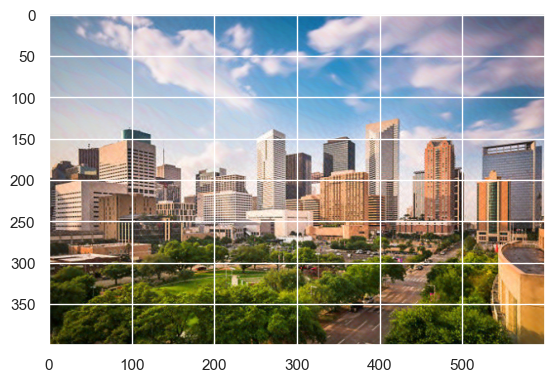

KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam([target], lr=0.003)
steps = 2000
show_every = 400

for ii in range(1, steps+1):
    target_features = get_features(target, model)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape

        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)

        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()